# 다양한 합성곱 신경망 구조
- 합성곱 신경망에서의 가중치 개수 계산
  - 특정 합성곱 층에서 필요한 가중치 개수 = input 채널 수 * 커널의 높이 * 커널의 너비 * output 채널의 수
  - 특정 합성곱 층에서 필요한 편향 개수 = output 채널 수(커널의 개수와 같다.)

- LeNet-5

- AlexNet
  - 과적합을 막기 위해 2가지 규제(Regularization) 기법을 적용함.
    - 1. 전결합층에 Dropout을 적용함.
      - Dropout은 매 iteration마다 랜덤으로 일정 비율의 뉴런을 비활성화하고 학습시킴.
      - 일반적으로 머신러닝에서 과적합은 데이터 셋 크기에 비해서 학습시켜야 할 매개변수들이 많을 때 잘 발생함.
      - Dropout에서는 더 적은 개수의 뉴런으로도 원하는 답을 얻을 수 있도록 유도하여 과적합을 예방함.
    - 2. 데이터 증강(data augmentation) 기법을 적용함.
      - data augmentation이란 주어진 학습 데이터 셋에 대해 각 데이터의 본질을 유지하는 특정 변환들을 가해 새로운 형태의 데이터를 만들어내는 기법

- VGGNet
  - 크기 3 커널 합성곱
  - 풀링 이후 채널 2배

- GoogleNet
  - stem layer
  - global average

- ResNet
  - skip-connection

- EfficientNet
  - 신경망 크기를 증가시킬 때, 채널 증가, 깊이 증가 및 입력 이미지 증가 비율을 최적화, 이미지 분류에 널리 활용되는 신경망 구조

# 전이 학습
- Transfer learning
  - 다른 데이터 셋에 대해 먼저 학습된 가중치를 새로운 데이터 셋에 대해 학습하기 위한 신경망의 가중치 초기값으로 사용하는 학습 방식을 전이 학습이라고 함.
  - 이전 작업에서 배운 지식이 새로운 작업에 큰 도움이 된다.
  - 복사할 수 있는 가중치는 모두 복사하고, 맨 마지막에 분류를 위한 가중치만 새로 만들어서 학습시키고자 함.
    - 가중치 초기화 이후의 학습 과정은 기존 합성곱 신경망 학습과 차이점이 없음.
    - 새로운 데이터 셋에서는 클래스 개수가 달라지므로 신경망 맨 마지막의 층은 새로 만들어주어야 함.

# 전이 학습(Transfer Learning)
  - Transfer Learning
    - 다른 데이터 셋에 대해 먼저 학습된 신경망의 가중치를 새로운 데이터 셋에 대해 학습하기 위한 신경망의 가중치 초기값으로 사용하는 학습 방식
    - 복사할 수 있는 가중치는 모두 복수하고, 맨 마지막에 분류를 위한 가중치만 새로 만들어서 학습시키고자 함.
    - 가중치 초기화 이후의 학습 과정은 기존 합성곱 신경망 학습과 차이점이 없음.
    - 새로운 데이터 셋에서는 클래스 개수가 달라지므로 신경망 맨 마지막의 층은 새로 만들어주어야 함.

In [1]:
#matplotlib 환경설정
%matplotlib inline

In [3]:
# License: BSD
# Author: Sasank Chilamkurthy

#필요 라이브러리 import
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import zipfile

cudnn.benchmark = True
plt.ion()   # 대화형 모드

In [4]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls /content/drive/MyDrive

 ants_bees.zip	    GoodNotes			       'Saveway_최종 보고서.pdf'
'Colab Notebooks'   KakaoTalk_20240624_025018864.mp4    tflite-realtime-image-classifier.zip
 deeplearning	    Presentation-권장우-알파양파.pptx


In [6]:
os.makedirs('/content/dataset')

In [7]:
with zipfile.ZipFile('/content/drive/MyDrive/ants_bees.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [8]:
# 데이터 증강 및 정규화
# 이미지 데이터 셋 불러오기 전에 데이터 증강 및 정규화에 대한 선언을 먼저 진행
# torchvision.transsforms에는 이미지 및 텐서에 적용 가능한 다양한 변환이 있음.
# 데이터 증강은 학습 데이터 셋에만 적용함에 유의
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [9]:
data_dir = '/content/dataset/ants_bees'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


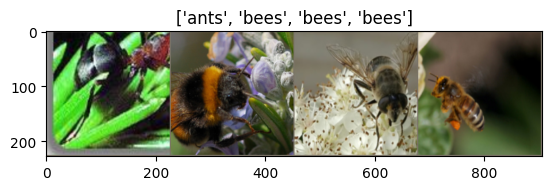

In [10]:
# 데이터셋 랜덤 샘플링 및 시각화
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
# 모델 학습을 위한 함수 구현
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 미니 배치 학습 루프
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [12]:
# Resnet training from scratch
model_ft = models.resnet18(pretrained=False, num_classes=2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/9
----------
train Loss: 0.7853 Acc: 0.5697
val Loss: 0.8615 Acc: 0.6275

Epoch 1/9
----------
train Loss: 0.6893 Acc: 0.6107
val Loss: 0.6626 Acc: 0.6275

Epoch 2/9
----------
train Loss: 0.7094 Acc: 0.5779
val Loss: 0.6706 Acc: 0.6405

Epoch 3/9
----------
train Loss: 0.7307 Acc: 0.5943
val Loss: 0.8604 Acc: 0.6013

Epoch 4/9
----------
train Loss: 0.7195 Acc: 0.5861
val Loss: 0.9368 Acc: 0.5817

Epoch 5/9
----------
train Loss: 0.6785 Acc: 0.5943
val Loss: 0.8044 Acc: 0.6863

Epoch 6/9
----------
train Loss: 0.6959 Acc: 0.5984
val Loss: 1.0432 Acc: 0.4771

Epoch 7/9
----------
train Loss: 0.6994 Acc: 0.6311
val Loss: 0.7035 Acc: 0.6536

Epoch 8/9
----------
train Loss: 0.7241 Acc: 0.6189
val Loss: 0.8847 Acc: 0.5752

Epoch 9/9
----------
train Loss: 0.6816 Acc: 0.6352
val Loss: 0.6757 Acc: 0.7190

Training complete in 0m 38s
Best val Acc: 0.718954


In [13]:
# Resnet training with transfer learning
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


Epoch 0/9
----------
train Loss: 0.8033 Acc: 0.6311
val Loss: 0.2521 Acc: 0.8889

Epoch 1/9
----------
train Loss: 0.4672 Acc: 0.7951
val Loss: 0.3013 Acc: 0.9020

Epoch 2/9
----------
train Loss: 0.5215 Acc: 0.7910
val Loss: 0.2939 Acc: 0.8824

Epoch 3/9
----------
train Loss: 0.5510 Acc: 0.7336
val Loss: 0.2670 Acc: 0.8889

Epoch 4/9
----------
train Loss: 0.4113 Acc: 0.8238
val Loss: 0.5008 Acc: 0.8170

Epoch 5/9
----------
train Loss: 0.4917 Acc: 0.7951
val Loss: 0.4481 Acc: 0.8627

Epoch 6/9
----------
train Loss: 0.6937 Acc: 0.7582
val Loss: 0.5697 Acc: 0.8627

Epoch 7/9
----------
train Loss: 0.5544 Acc: 0.8279
val Loss: 0.4885 Acc: 0.8366

Epoch 8/9
----------
train Loss: 0.6143 Acc: 0.7664
val Loss: 0.2723 Acc: 0.9020

Epoch 9/9
----------
train Loss: 0.7994 Acc: 0.7377
val Loss: 0.4176 Acc: 0.8170

Training complete in 0m 39s
Best val Acc: 0.901961


In [14]:
# EfficientNetV2 training from scratch
model_ft = models.efficientnet_v2_s(pretrained=False, num_classes=2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=10)

Epoch 0/9
----------
train Loss: 3.2051 Acc: 0.5410
val Loss: 40.4350 Acc: 0.4967

Epoch 1/9
----------
train Loss: 1.7314 Acc: 0.5451
val Loss: 193.0226 Acc: 0.6471

Epoch 2/9
----------
train Loss: 1.7364 Acc: 0.5451
val Loss: 35.9161 Acc: 0.5098

Epoch 3/9
----------
train Loss: 1.5257 Acc: 0.5205
val Loss: 28.7910 Acc: 0.5098

Epoch 4/9
----------
train Loss: 1.4056 Acc: 0.4672
val Loss: 42.8049 Acc: 0.4575

Epoch 5/9
----------
train Loss: 1.1587 Acc: 0.4754
val Loss: 67.5990 Acc: 0.4444

Epoch 6/9
----------
train Loss: 1.0198 Acc: 0.5451
val Loss: 27.3620 Acc: 0.5098

Epoch 7/9
----------
train Loss: 1.2365 Acc: 0.5000
val Loss: 20.1983 Acc: 0.5294

Epoch 8/9
----------
train Loss: 1.0700 Acc: 0.5697
val Loss: 42.7865 Acc: 0.3856

Epoch 9/9
----------
train Loss: 1.1529 Acc: 0.5369
val Loss: 60.3925 Acc: 0.5621

Training complete in 1m 20s
Best val Acc: 0.647059


In [15]:
# EfficientNetV2 training with transfer learning
model_ft = models.efficientnet_v2_s(pretrained=True)
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 159MB/s]


Epoch 0/9
----------
train Loss: 0.5724 Acc: 0.7008
val Loss: 0.3409 Acc: 0.9281

Epoch 1/9
----------
train Loss: 0.3771 Acc: 0.8361
val Loss: 0.2456 Acc: 0.9346

Epoch 2/9
----------
train Loss: 0.3206 Acc: 0.8566
val Loss: 0.2373 Acc: 0.9542

Epoch 3/9
----------
train Loss: 0.3414 Acc: 0.8361
val Loss: 116.5554 Acc: 0.9281

Epoch 4/9
----------
train Loss: 0.3125 Acc: 0.8770
val Loss: 0.2085 Acc: 0.9477

Epoch 5/9
----------
train Loss: 0.2701 Acc: 0.8893
val Loss: 0.1746 Acc: 0.9542

Epoch 6/9
----------
train Loss: 0.2604 Acc: 0.8893
val Loss: 0.1846 Acc: 0.9542

Epoch 7/9
----------
train Loss: 0.2918 Acc: 0.8648
val Loss: 0.1973 Acc: 0.9412

Epoch 8/9
----------
train Loss: 0.2448 Acc: 0.9057
val Loss: 0.1971 Acc: 0.9608

Epoch 9/9
----------
train Loss: 0.2692 Acc: 0.8730
val Loss: 0.1702 Acc: 0.9477

Training complete in 1m 23s
Best val Acc: 0.960784


# 전이 학습 실습 및 구현
- 실험 결과 정리
  -  성능 순위
    - EfficientNetV2 전이학습 > ResNet 전이학습 > ResNet 초기화 후 학습 > EfficientNetV2 초기화 후 학습
  
  - 이처럼 새로운 이미지 분류 문제에 대해선 다양한 모델을 적용해 볼 수 있으며, 다만 전이학습이 좋을지 초기화 후 학습이 좋을지는 특정 모델로도 확인 가능함.
